## PROPOSAL AND IMPLEMENTATION

In [1]:
from matplotlib import pyplot as plt
import networkx as nx
import random
import scipy.stats as stats
import numpy as np

In [17]:
class SocialDynamicsSimulation:
    '''
    Simulate social dynamics by strengthening opinions and connection weights
    based on random interactions between nodes.
    '''

    def __init__(self):
        
        '''
        1st modification: Personalized parameters
        
            Personalized parameters: Each person has their own alpha, beta, gamma used for 
                modifying connection. The personalized parameters will be pulled out from 
                a list of distribution specified below. 
            
            Update rule: 
            
                alpha (float) The rate at which nodes adjust their opinions to
                  match neighboring nodes' opinions during interactions.
                  
                  Distribution: beta distribution 
                  Hyperparameter: 
                      alpha: 0.5
                      beta: 10 
                  
                  Reasoning: The opinion adjustment should be small as it will take multiple interactions
                  to change the opinions of one person. The beta distribution (alpha = 2, beta = 10) has the 
                  upper bound to be 1, and the shape of the distribution skewed to the right
                  => small amount of changing opinions

                
                beta (float) The rate at which edge weights are changed in
                  response to differing opinions. 
                  
                  Distribution: beta distribution 
                  Hyperparameter: 
                      alpha: 2
                      beta: 10 
                  
                  Reasoning: The opinion adjustment should be small but not that small compared to alpha. 
                  The edge weight updating is the multiplication of many float number < 1, which has been small 
                  already. The beta distribution above has the peak at around 0.1 and skewed to the right. 

                
                gamma (float) The pickiness of nodes. Nodes with opinions differing
                  by more than 1/gamma will result in an edge weight decreasing.
                  
                  Distribution: Gamma distribution
                  Hyperparameter: 
                      shape = 3
                      scale = 2
                  
                  Reasoning: The distribution of gamma distribution as defined above has a peak at around 4. 
                  The support of the distribution is a float number larger than 0, which makes it reasonable to 
                  choose. 
                  
                  Condition: gamma > 1. 
            
            '''

    def initialize(self, network_size=50):
        '''
        Initialize the simulation with a random graph, with random 0 or 1
        opinions assigned to all nodes and initial edge weights of 0.5.
        '''
        self.graph = nx.barabasi_albert_graph(network_size, 4)
        for edge in self.graph.edges:
            self.graph.edges[edge]['weight'] = 0.5
        for node in self.graph.nodes:
            self.graph.nodes[node]['opinion'] = random.randint(0, 1)
            self.graph.nodes[node]['alpha'] = stats.beta (0.5, 10).rvs(1)[0]
            self.graph.nodes[node]['beta'] = stats.beta (2, 10).rvs(1)[0]
            while True: 
                gamma = stats.gamma (3,2).rvs(1)[0]
                if gamma > 1 and gamma >= 1-1/self.graph.nodes[node]['beta']\
                and gamma <= 1+1/self.graph.nodes[node]['beta'] :
                    break
            self.graph.nodes[node]['gamma'] = gamma
        self.layout = nx.spring_layout(self.graph)  # Initial visual layout
        self.step = 0

    def initialize_2(self, network_size=50):
        '''
        Initialize the simulation with a random graph, with random 0 or 1
        opinions assigned to all nodes and initial edge weights of 0.5.
        '''
        self.graph = nx.nx.watts_strogatz_graph(network_size, 5, 0.5)
        for edge in self.graph.edges:
            self.graph.edges[edge]['weight'] = 0.5
        for node in self.graph.nodes:
            self.graph.nodes[node]['opinion'] = random.randint(0, 1)
            self.graph.nodes[node]['alpha'] = stats.beta (0.5, 10).rvs(1)[0]
            self.graph.nodes[node]['beta'] = stats.beta (2, 10).rvs(1)[0]
            while True: 
                gamma = stats.gamma (3,2).rvs(1)[0]
                if gamma > 1 and gamma >= 1-1/self.graph.nodes[node]['beta']\
                and gamma <= 1+1/self.graph.nodes[node]['beta'] :
                    break
            self.graph.nodes[node]['gamma'] = gamma
        self.layout = nx.spring_layout(self.graph)  # Initial visual layout
        self.step = 0
        
        
    def observe(self, para_details = False):
        '''
        Draw the state of the network.
        '''
        if para_details == True:
            alpha_sample = []
            beta_sample = []
            gamma_sample = []
            weights = []
            for i in self.graph.nodes: 
                alpha_sample.append(self.graph.nodes[i]['alpha'])
                beta_sample.append(self.graph.nodes[i]['beta'])
                gamma_sample.append(self.graph.nodes[i]['gamma'])
            for i in self.graph.edges:
                weights.append (self.graph.edges[i]['weight'])
            print ('Parameter: alpha {:.2f}, beta {:.2f}, gamma {:.2f}'.format(np.mean(alpha_sample),
                                                                               np.mean(beta_sample), np.mean(gamma_sample)))

            cluster = nx.average_clustering(self.graph, weight= True)
            print ('Clustering value {:.2f}'.format (cluster))

        self.layout = nx.spring_layout(self.graph, pos = self.layout, iterations=5)
        plt.clf()
        nx.draw(
            self.graph, pos=self.layout, with_labels=True,
            node_color=[self.graph.nodes[i]['opinion'] for i in self.graph.nodes],
            edge_color=[self.graph.edges[i, j]['weight'] for i, j in self.graph.edges],
            edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=1,
            alpha=0.7, vmin=0, vmax=1)
        plt.title('Step: ' + str(self.step))
        print ('')

        
    def update(self, prob=0.05):
        
        '''
        2nd revision: New relationships
            
            On the other hand, it is a common practice that people make a new connection via referral. 
                The modification below will highlight the probability of making a new connection via referral 
                depending on how strong the connections are (measuring weight along the line). Of course, 
                there is still room for making a random connection without a referral, but such value is pretty small. 

            
            Update rule: 
                The probability for making connection will be increased to 0.05, which means that
                for each time step, a node has a 5% of making a connection. However, it is possible 
                that the node is unable to make a connection if the below condition does not meet. In reality, 
                when you have a dinner via referral but the initial conversation does not go well,
                you don't make a new connection. 
                
                For a time step, we will check the nodes which are not the neighbor of the node of interest. 
                We will check the shortest path between the node (referral path) and take the multiplication
                of all the weights along the shortest path. In real life situation, the further the connection, 
                the harder it is to make connection. Thus, the multiplication will take into account the
                discounting effect when going through different connection. 
                
                For example: 
                    w_i_k = 0.5
                    w_k_k_2 = 0.4
                    
                The multiplication (0.5*0.4) needs to pass the threshold to have establish a connection. 
                
                The threshold for this value is sampled from a beta distribution. 
                I expect this threshold to be around 0.15, which equals to making connection via 2 referrals
                (0.6*0.5*0.5). The distribution detail is listed below:
                
                    Distribution: Normal distribution
                    Hyperparameter: 
                        loc = 0.15
                        scale = 0.05
                
                If a new connection is established, the weight will be randomly chosen from a normal distribution
                    with hyperparameter as follows: 
                        loc = 1 - difference between two opinions
                        scale = 0.3
                    
                    Condition: float number > 0 
                    
        '''
        if random.uniform(0, 1) < 0.05:
            # For 5% chance, check if we can make a connection between two people
            nodes = list(self.graph.nodes)
            while True:
                new_edge = random.sample(nodes, 2)
                if new_edge not in self.graph.edges:
                    break
            #Calculate the multiplication of all the weights of edges along the path
            try: 
                path = nx.shortest_path(self.graph,new_edge[0], new_edge[1])
                value = 1
                for i in range (len(path)-1):
                    value *= self.graph.edges[path[i], path[i+1]]['weight']
            
            #Evaluate the threshold between the two nodes
                if value > stats.norm (0.15, 0.05).rvs(1)[0]:
                    while True:
                        weight = stats.norm (1-abs(self.graph.nodes[new_edge[0]]['opinion']- 
                                          self.graph.nodes[new_edge[1]]['opinion']),0.3).rvs(1)[0]
                        if weight > 0:
                            break
                    self.graph.add_edge(new_edge[0], new_edge[1], weight=0.5)
            
            except:
                pass
            
        else:
            # Select a random edge and update node opinions and edge weight
            edge = random.choice(list(self.graph.edges))
            weight = self.graph.edges[edge]['weight']
            opinions = [self.graph.nodes[n]['opinion'] for n in edge]
            alphas = [self.graph.nodes[n]['alpha'] for n in edge]
            betas = [self.graph.nodes[n]['beta'] for n in edge]
            gammas = [self.graph.nodes[n]['gamma'] for n in edge]
            for i in [0, 1]:
                self.graph.nodes[edge[i]]['opinion'] = (
                    opinions[i] + alphas[i] * weight * (opinions[1-i] - opinions[i]))
            self.graph.edges[edge]['weight'] = (
                weight +
                betas [random.choice([0,1])]* weight * (1-weight) *
                (1 - gammas [random.choice([0,1])] * abs(opinions[0] - opinions[1])))
            # Remove very weak connections
            if self.graph.edges[edge]['weight'] < 0.05:
                self.graph.remove_edge(*edge)
        self.step += 1

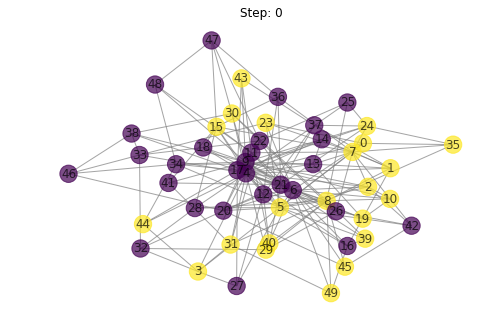

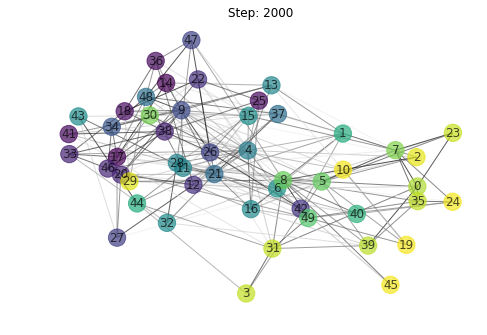

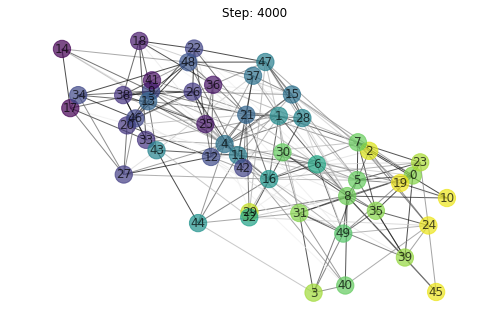

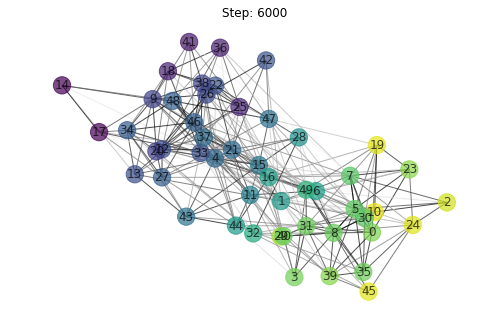

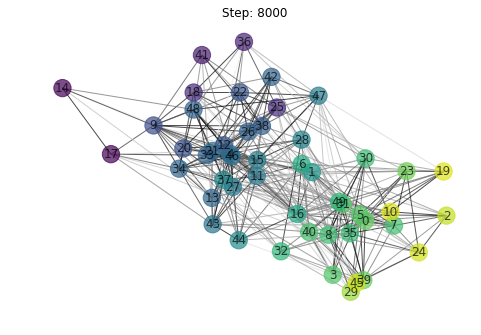

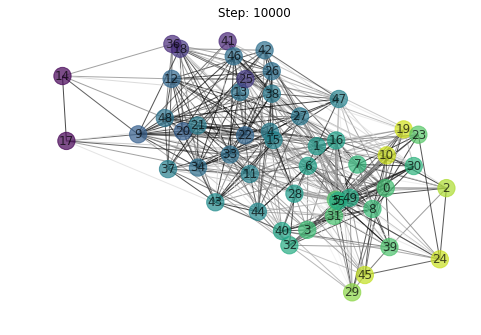

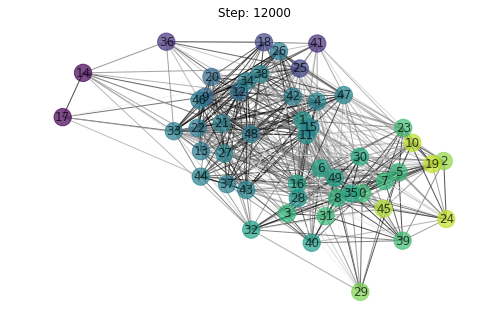

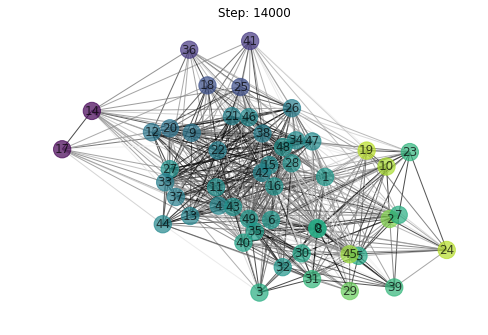

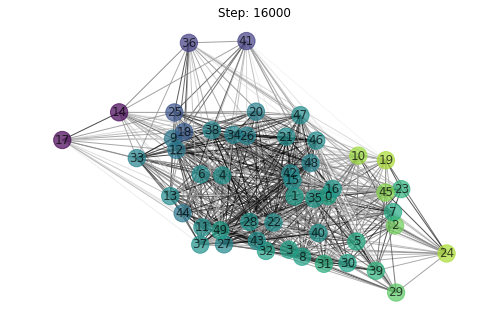

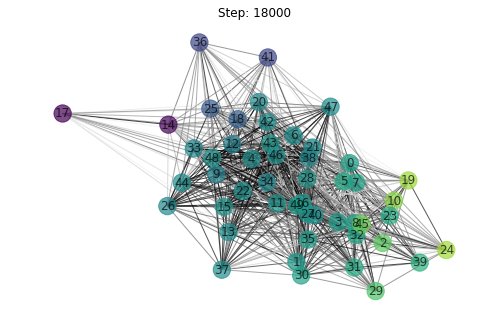

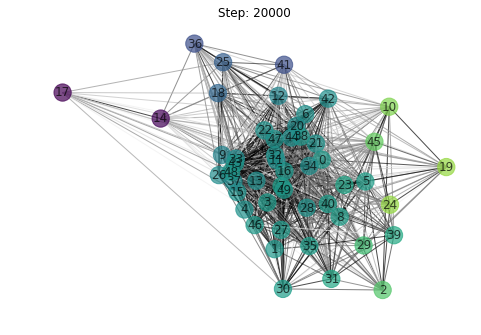

In [3]:
sim = SocialDynamicsSimulation()
sim.initialize(50)
plt.figure()
sim.observe()
for i in range(10):
    for i in range(2000):
        sim.update()
    plt.figure()
    sim.observe()

### LOCAL ANALYSIS NUMBER OF EDGES

In [4]:
beginning =[]
edges = []
for i in range(1000):
    sim = SocialDynamicsSimulation()
    sim.initialize(10)
    beginning.append(sim.graph.number_of_edges())
    for i in range (200):
        sim.update()
    edges.append(sim.graph.number_of_edges())

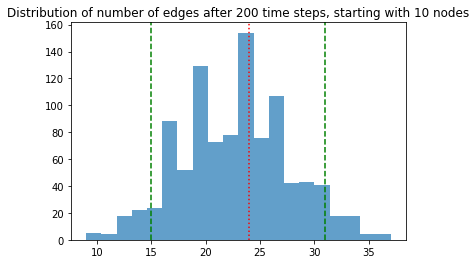

95% of the number of edges after 200 time steps ranges from 15.0 to 31.0
The number of edges at the beginning is 24


In [5]:
five = np.percentile (edges, 5)
ninety_five = np.percentile (edges, 95)
plt.hist (edges, bins = 20, alpha = 0.7)
plt.axvline (five, linestyle = '--', color = 'green')
plt.axvline (ninety_five, linestyle = '--', color = 'green')
plt.axvline (np.mean(beginning), linestyle = ':', color = 'red')
plt.title ('Distribution of number of edges after 200 time steps, starting with 10 nodes')
plt.show()
print ('95% of the number of edges after 200 time steps ranges from {:.1f} to {:.1f}'.format (five, ninety_five))
print ('The number of edges at the beginning is {:.0f}'.format(np.mean(beginning)))

### LOCAL ANALYSIS THE EFFECT OF PERSONAL PARAMETERS

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def vector_plot():
    # Create grid coordinates
    x = np.linspace(0,1, 10)
    y = np.linspace(0,1, 10)
    x_grid, y_grid = np.meshgrid(x, y)

    alpha = stats.beta (0.5, 10).rvs(1)[0]
    beta = stats.beta (2, 10).rvs(1)[0]
    while True: 
        gamma_test = stats.gamma (3,2).rvs(1)[0]
        if gamma_test > 1 and gamma_test >= 1-1/beta and gamma_test <= 1+1/beta :
            break
    gamma = gamma_test

    # Compute vector field
    opinion_diff = -2 * alpha * y_grid * x_grid
    weight = beta*y_grid*(1-y_grid)*(1 - gamma*x_grid)

    # Plot vector field
    plt.figure(figsize=(8, 8))
    plt.xlabel ('opinion difference')
    plt.ylabel ('weight')
    plt.axhline (0.05, linestyle = '--')
    plt.quiver(x_grid, y_grid, opinion_diff, weight)
    plt.title('alpha = {:.2f}, beta = {:.2f}, gamma = {:.2f}'.format (alpha, beta, gamma))
    plt.show()

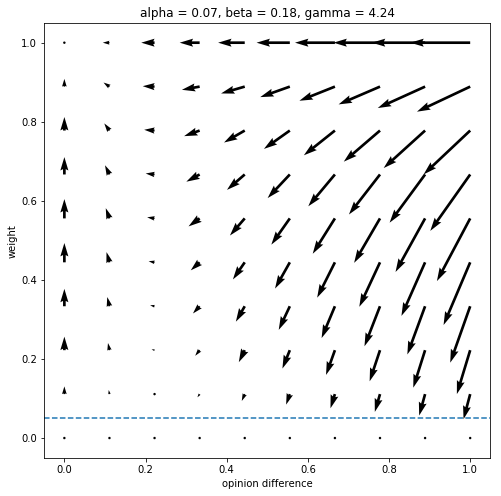

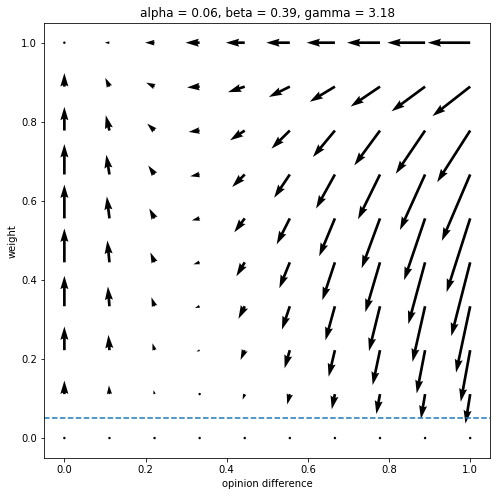

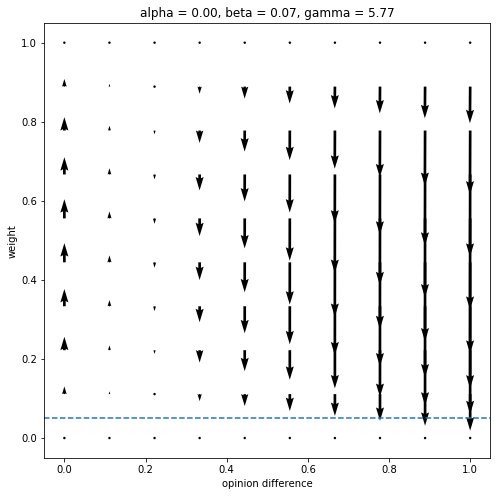

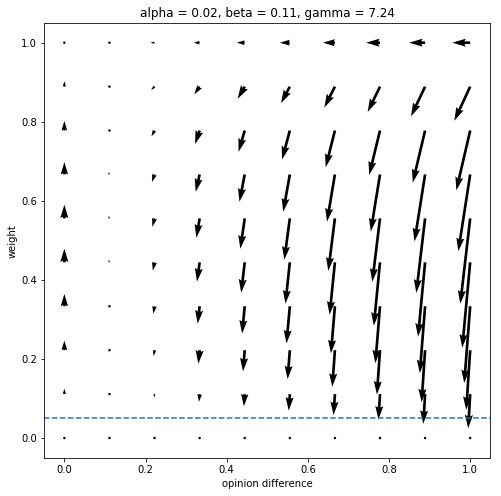

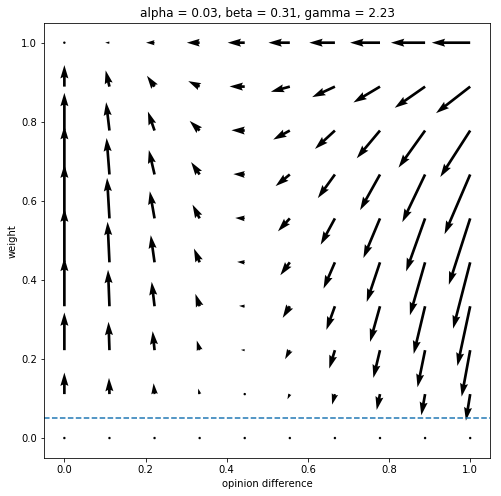

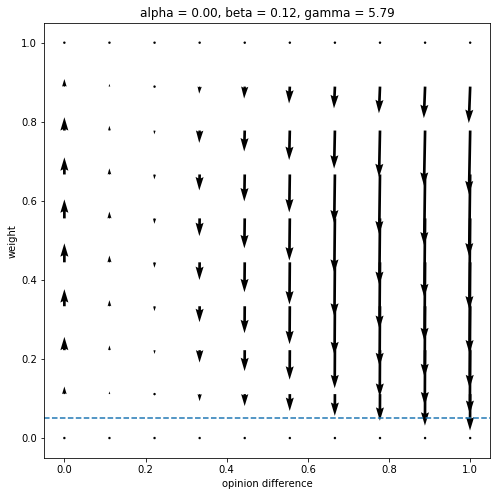

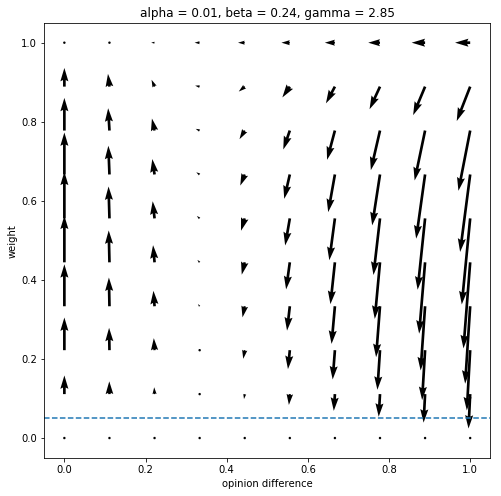

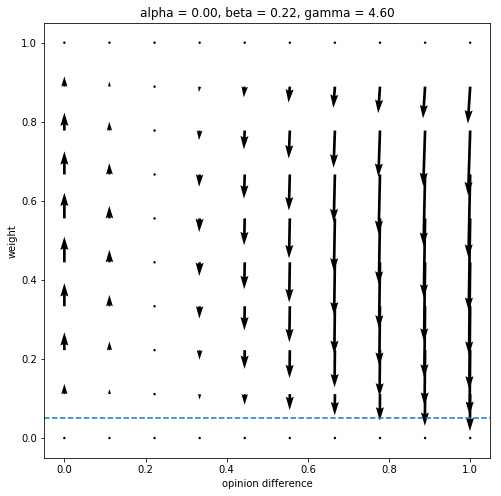

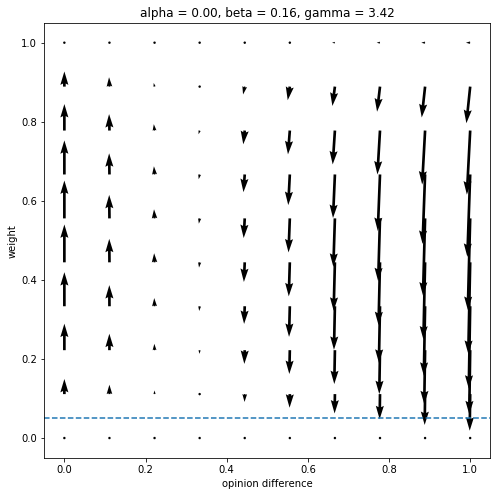

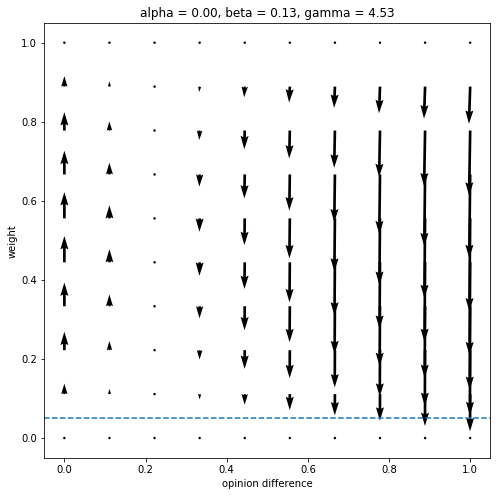

In [7]:
#Plot the vector graph
for i in range (10):
    vector_plot()

## SIMULATION ANALYSIS

Parameter: alpha 0.04, beta 0.17, gamma 4.30
Clustering value 0.48

Parameter: alpha 0.05, beta 0.21, gamma 4.53
Clustering value 0.52

Parameter: alpha 0.05, beta 0.18, gamma 4.65
Clustering value 0.53

Parameter: alpha 0.06, beta 0.17, gamma 4.97
Clustering value 0.66

Parameter: alpha 0.04, beta 0.16, gamma 4.33
Clustering value 0.55



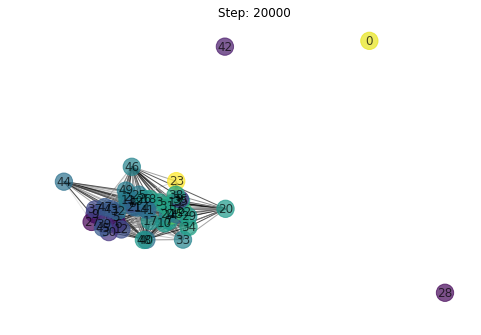

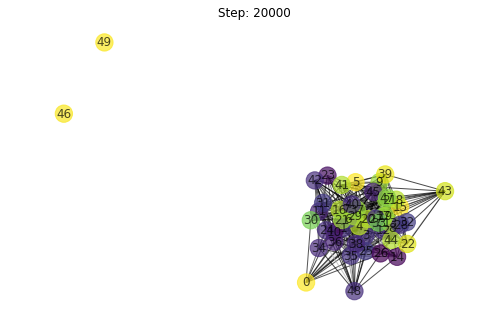

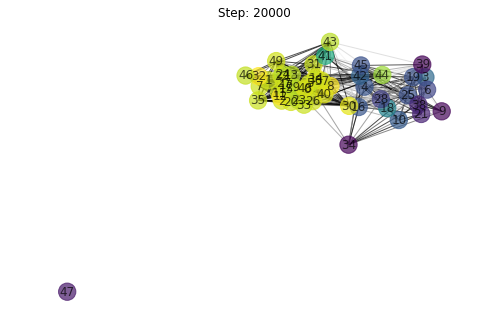

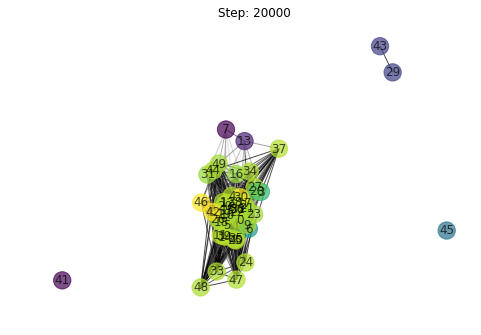

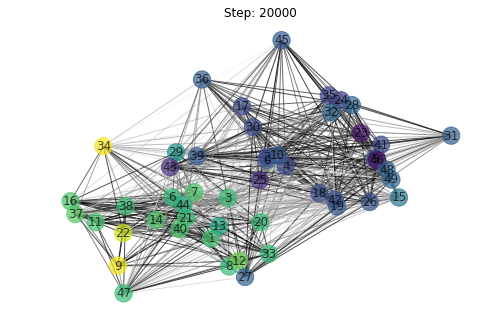

In [16]:
final = [] #store the clustering value at the 20000 time step
alpha = [] #store the average alpha value of the model
beta = [] #store the average beta value of the model
gamma = [] #store the average gamma value of the model
sim = SocialDynamicsSimulation()
for i in range (5):
    sim.initialize(50)   
    #Run the simulation 20000 time-step and present the result
    for i in range(20000):
        sim.update(prob=0.01)
    plt.figure()
    sim.observe(para_details = True)    

Parameter: alpha 0.04, beta 0.17, gamma 4.24
Clustering value 0.58

Parameter: alpha 0.06, beta 0.18, gamma 4.57
Clustering value 0.66

Parameter: alpha 0.06, beta 0.17, gamma 4.55
Clustering value 0.54

Parameter: alpha 0.05, beta 0.16, gamma 4.43
Clustering value 0.46

Parameter: alpha 0.05, beta 0.15, gamma 4.62
Clustering value 0.54



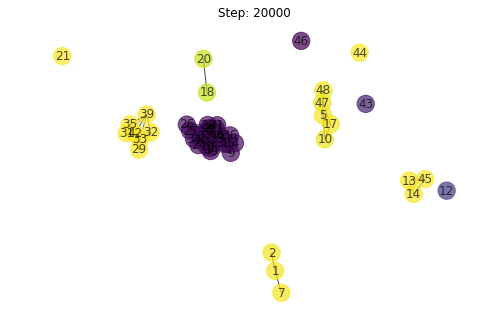

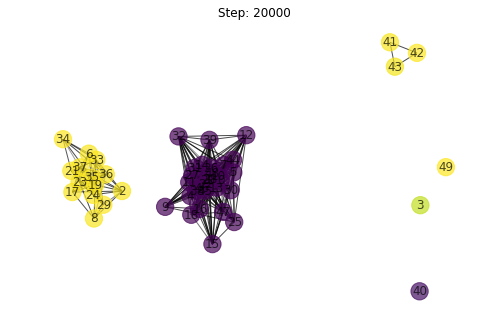

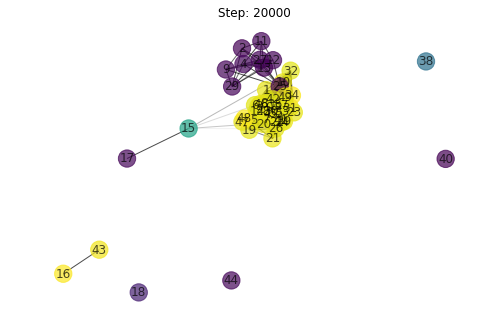

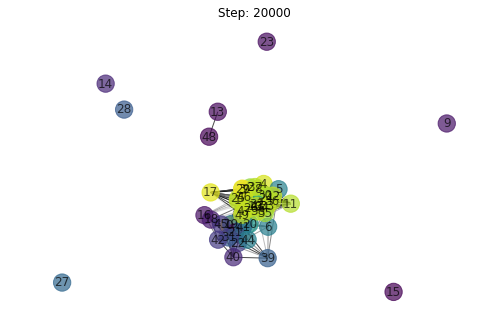

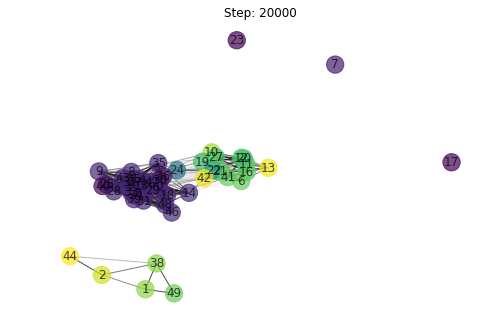

In [19]:
final = [] #store the clustering value at the 20000 time step
alpha = [] #store the average alpha value of the model
beta = [] #store the average beta value of the model
gamma = [] #store the average gamma value of the model
sim = SocialDynamicsSimulation()
for i in range (5):
    sim.initialize_2(50)   
    #Run the simulation 20000 time-step and present the result
    for i in range(20000):
        sim.update(prob=0.01)
    plt.figure()
    sim.observe(para_details = True)    